# Домашняя работа №9.1

## Цели и задачи домашней работы:

1) Написать алгоритм, который будет принимать на вход 2 изображения минимум с 20%-ым перекрытием изображения (пример: фото объектов, полученные с помощью обычной и широкоугольных камер);
2) Написать алгоритм для поиска общих точек между двумя изображениями;
3) Рассчитать матрицу афинного преобразования для данных изображений;
4) Выполнить разложение данной матрицы на составляющие и выполнить процедуру ее восстановления, проверить равенство исходной и восстановленной матриц;
5) Получить значения угла переноса, коэффициента масштабирования изображения и вектора трансляции в явном виде для матрицы афинного преобразования.

## Подготовка

Для начала работы, нам необходимы изображения. При помощи обычной и широкоугольной камер, были полученны два изображения с минимум 20%-ым перекрытием объектов. Сохраним их, как: "Image_1.jpeg", "Image_2.jpeg".

Для всех дальнейших манипуляций с изображениями, импортируем следующие библиотеки:

In [23]:
import cv2;
import matplotlib.pyplot as plt;
import numpy as np;

## 1. Получение двух изображений 

Для получения двух изображений применим метод "cv2.imread()" из библиотеки "OpenCV":

In [27]:
image_1 = cv2.imread("Image_1.jpeg");
image_2 = cv2.imread("Image_2.jpeg");

## 2. Алгоритм поиска общих точек для двух изображений

### Краткое описание детекторов

Детектор "SIFT" представляет собой способ определения дисперсии масштабирования ключевых точек изображения.
Алгоритм работы детектора "SIFT" можно разделить на две части: определение ключевых точек и извлечение дескрипторов ключевых точек.
Определение ключевой точки реализованно путем применения аппроксимации Лапласса к матрице Гаусса, что решает проблему масштабной дисперсии, однако является трудозотратаным процессом с точки зрения выислительных мощностей. Рассчитывается сетка из преобразованных матриц и затем определяются локальные экстремумы в облоасти 3х3х3, которые будут идентифицированы как ключевые точки.
Каждой ключевой точке также присваивается ориентация. Это происходит путем выделения окрестностей вокруг ключевой точки и создания гистограммы ориентации, где в качестве точки ориентации используется пиковая точка гистограммы, хотя для расчета также учитывается любое другое пиковое значение гистограммы, относительное значение которого превышает 0.8.
Для генерации дескриптора выбирается окрестность вокруг ключевой точки размером 16x16 и делится на ячейки размером 4x4. Для каждой ячейки вычисляется гистограмма ориентации, а объединенные гистограммы объединяются в дескриптор объекта. 


Детектор "ORB" представляет собой комбинацию двух алгоритмов: "FAST" и "BRIEF". В качестве детектора ключевых точек используется алгоритм "FAST" ("Features from Accelerated Segment Test"). Он работает путем выбора пикселей в радиусе вокруг потенциальной ключевой точки и проверяет, есть-ли непрерывные пиксели, которые ярче или темнее, чем исследуемый пиксель. Процесс ускоряется за счет сравнения только подмножества этих пикселей перед тестированием всего диапазона. Следует отметить, что "FAST" не вычисляет ориентацию. Для решения этой проблемы "ORB" использует центроид пятна ключевой точки с набором весов интенсивности пикселей, а направление этого центроида относительно ключевой точки используется в качестве ориентации. В качестве дескриптора ключевой точки используется алгоритм "BRIEF" ("Binary Robust Independent Elementary Features"). Поскольку "BRIEF" плохо справляется с вращением, вычисленная ориентация ключевых точек используется для определения ориентации участка ключевой точки перед извлечением дескриптора. Как только это будет сделано, будет вычислена серия двоичных тестов, сравнивающих набор пикселей. Результаты двоичных тестов объединяются и используются в качестве дескриптора объекта.

### Реализация алгоритма

Для начала, напишем функцию "extract_features_function()", которая принимает на вход следующие аргументы: "image_file", "detector_type", "mask", где:
1) "image_file" - файл изображения;
2) "detector_type" - тип детектора;
3) "mask" - маска, применямая к изображению.
Будем использовать детекторы двух типов: "SIFT", "ORB".

Реализуем функцию с использованием конструкции "try-catch", которая поможет избежать части ошибок во время выполнения алгоритма, а также будет использоваться в последующих функциях с этой-же целью: 

In [94]:
def extract_features_function(image_file, detector_type, mask = None):
    try:
        if detector_type != "sift" and detector_type != "orb":
            raise AttributeError("Детектора такого типа не существует! Доступные типы детекторов: 'sift', 'orb'");
        if detector_type == "sift":
            detector_type = cv2.SIFT_create();
        if detector_type == "orb":
            detector_type = cv2.ORB_create();
        key_points, descriptor = detector_type.detectAndCompute(image_file, mask);
    except:
        raise BaseException("Ошибка аттрибутов функции 'extract_features_function()'!");
    return key_points, descriptor;

Функция "extract_features_function()" возвращает набор точек объекта и их дескрипторы.

Для поиска совпадений ключевых точек между двумя изображениями, реализуем функцию "matches_features_function()", которая принимает на вход следующие аргументы: 
1) "descripor_1" - набор дескрипоторов первого изображения;
2) "descriptor_2" - набор дескрипоторов второго изображения;
3) "matching_type" - тип поиска (используем только тип "BF" ("Best Fit"));
4) "detector_type" - тип детектора;
5) "sort = True";
6) "k = 2".

In [98]:
def matches_features_function(descripor_1, descriptor_2, matching_type, detector_type, sort = True, k = 2):
    try:
        if matching_type == "BF":
            if detector_type != "sift" and detector_type != "orb":
                raise AttributeError("Детектора такого типа не существует! Доступные типы детекторов: 'sift', 'orb'");
            if detector_type == "sift":
                matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck = False);
            if detector_type == "orb":
                matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck = False);
            try:
                matches = matcher.knnMatch(descriptor_1, descriptor_2, k = k);
            except:
                raise BaseException("Измените тип детектора для изображений на 'orb'"); 
        elif matching_type != "BF":
            raise TypeError("Метода поиска такого типа не существует! Доступные типы методов поиска: 'BF'");      
        if sort:
            matches = sorted(matches, key = lambda x:x[0].distance);
    except:     
        raise BaseException("Ошибка аттрибутов функции 'matches_features_function()'!");
    return matches;

Функция "matches_features_function()" возвращает набор точек, котрые являются общими для двух изображений.

Реализуем функцию "filter_matches_function()", которая принимает на вход следующие аргументы:
1) "matches" - набор точек, котрые являются общими для двух изображений;
2) "distance_threshold" - критерий ошибки, который будет являтся основанием для исключения точек из набора "matches".

In [102]:
def filter_matches_function(matches, distance_threshold):
    try:
        filtered_matches = [];
        for a, b in matches:
            if a.distance <= distance_threshold * b.distance:
                filtered_matches.append(a);
    except:
        raise BaseException("Ошибка аттрибутов функции 'filter_matches_function()'!");        
    return filtered_matches;

Функция "matches_features_function()" возвращает отфильтрованный набор точек, котрые являются общими для двух изображений.

Реализуем функцию "visualize_matches_function()", которая принимает на вход следующие аргументы:
1) "image_1" - файл первого изображения;
2) "key_points_1" - набор точек первого объекта;
3) "image_2" - файл второго изображения;
4) "key_points_2" - набор точек второго объекта;
5) "filtered_matches" - отфильтрованный набор точек, котрые являются общими для двух изображений.

In [106]:
def visualize_matches_function(image_1, key_points_1, image_2, key_points_2, filtered_matches):
    try:
        image_matches = cv2.drawMatches(image_1, key_points_1, image_2, key_points_2, filtered_matches, None, flags = 2);
        plt.figure(figsize = (16, 6), dpi = 100);
        plt.imshow(image_matches);
        plt.axis("off");
        plt.savefig("Combined_matches_image.jpeg", bbox_inches = "tight", pad_inches = 0);
        print("Комбинированное изображение сохранено в директорию проекта как растровое изображение: 'Combined_matches_image.jpeg'");
    except:
        raise BaseException("Ошибка аттрибутов функции 'visualize_matches_function()'!");


Произведем расчет точек посредством алгоритма "SIFT":

Число совпадений ключевых точек до фильтрации: 4392
Число совпадений ключевых точек после фильтрации: 65
Комбинированное изображение сохранено в директорию проекта как растровое изображение: 'Combined_matches_image.jpeg'


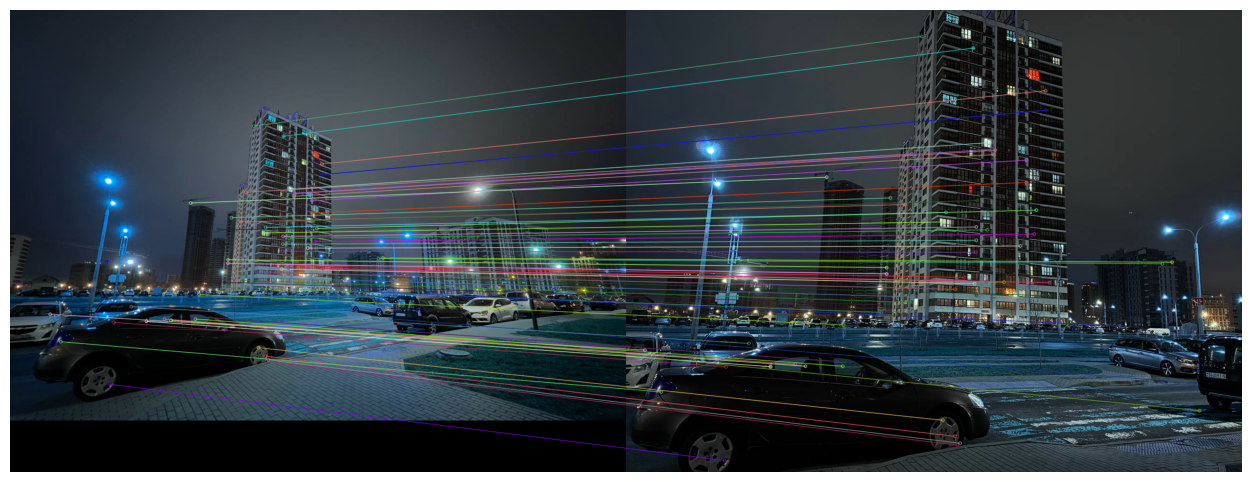

In [112]:
key_points_1, descriptor_1 = extract_features_function(image_1, "sift");
key_points_2, descriptor_2 = extract_features_function(image_2, "sift");

matches_between_images = matches_features_function(descriptor_1, descriptor_2, "BF", "sift", sort = True);
print("Число совпадений ключевых точек до фильтрации:", len(matches_between_images));
filterd_matches_between_images = filter_matches_function(matches_between_images, 0.345);
print("Число совпадений ключевых точек после фильтрации:", len(filterd_matches_between_images));

visualize_matches_function(image_1, key_points_1, image_2, key_points_2, filterd_matches_between_images);

Произведем расчет точек посредством алгоритма "ORB":

Число совпадений ключевых точек до фильтрации: 500
Число совпадений ключевых точек после фильтрации: 6
Комбинированное изображение сохранено в директорию проекта как растровое изображение: 'Combined_matches_image.jpeg'


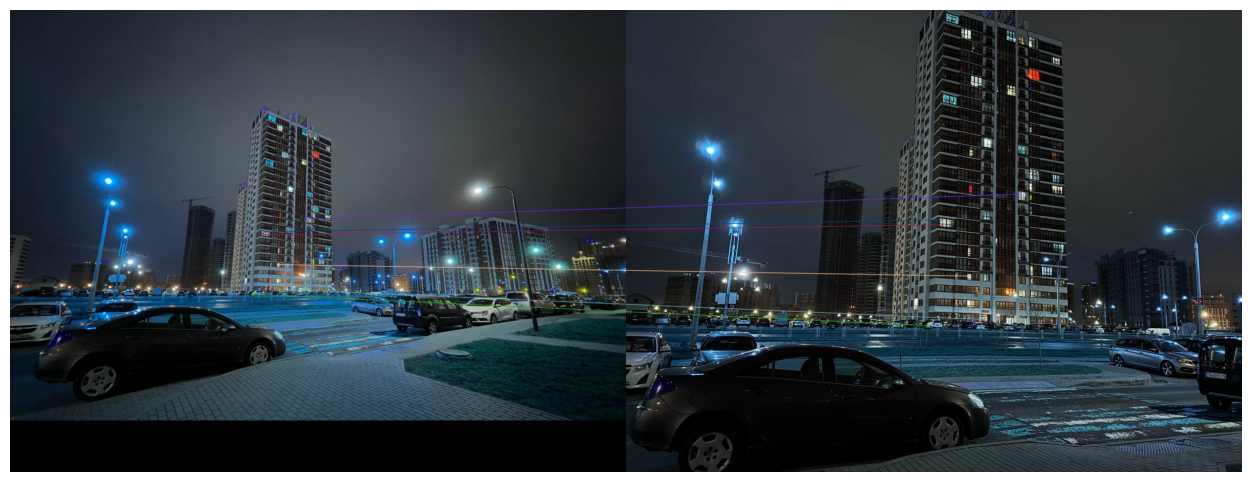

In [117]:
key_points_1, descriptor_1 = extract_features_function(image_1, "orb");
key_points_2, descriptor_2 = extract_features_function(image_2, "orb");

matches_between_images = matches_features_function(descriptor_1, descriptor_2, "BF", "orb", sort = True);
print("Число совпадений ключевых точек до фильтрации:", len(matches_between_images));
filterd_matches_between_images = filter_matches_function(matches_between_images, 0.345);
print("Число совпадений ключевых точек после фильтрации:", len(filterd_matches_between_images));

visualize_matches_function(image_1, key_points_1, image_2, key_points_2, filterd_matches_between_images);

Можно сделать вывод, что алгоритм "SIFT" находит большее количество общих точек между двумя изображениями.

## 3.Расчет матрицы афинного преобразования 

Для расчет матрицы афинного преобразования и соверешния над ней ряда действий, реализуем алгоритм при помощи ряда функций.

Реализуем функцию "transform_matrix_function()", которая принимает на вход следующие аргументы:
1) "transform_values_1" - массив ключевых точек для первого изображения в формате np.float32 (каждая ключевая точка представляется как массив с двумя координатами);
2) "transform_values_2" - массив ключевых точек для второго изображения в формате np.float32 (каждая ключевая точка представляется как массив с двумя координатами);
3) "method" - метод оценки матрицы афинного преобразования.

In [122]:
def transform_matrix_function(transform_values_1, transform_values_2, method):
    try:
        transform_matrix = cv2.estimateAffine2D(np.array(transform_values_2), np.array(transform_values_1),method = method)[0];    
        if transform_matrix is not None:
            dx = transform_matrix[0, 2];
            dy = transform_matrix[1, 2];
            da = np.arctan2(transform_matrix[1, 0], transform_matrix[0, 0]);
        else:
            dx = dy = da = 0;
    except:
        raise BaseException("Ошибка вычисления dx, dy, da и матрицы преобразования!");
    return [dx, dy, da], transform_matrix;

Функция "transform_matrix_function()" возвращает параметры сдвига и вращения и матрицу афинного преобразования, которая будет использоваться для преобразования общих точек между двумя изображениями.

## 4. Разложение и восстановление матрицы афинного преобразования

Реализуем функцию "decompose_image_affine_matrix_function()", которая принимает на вход аргумент "image_afine_transform_matrix", который представляет собой афинную матрицу преобразования для пары изображений.

In [136]:
def decompose_image_affine_matrix_function(image_afine_transform_matrix):
    try:
        if image_afine_transform_matrix.shape != (3, 3) or image_afine_transform_matrix.dtype != np.float64:
            raise ValueError("Неверная размерность матрицы! Матрица должна иметь размерность 3х3");
        R = image_afine_transform_matrix[:2, :2];
        U, W, Vt = np.linalg.svd(R);
        rotation = np.dot(U, Vt);
        scaling = np.diag(W);
        translation = image_afine_transform_matrix[:2, 2:];
    except:
        raise BaseException("Ошибка декомпозиции матрицы афинного преобразования!");
    return rotation, translation, scaling;

Функция "decompose_image_affine_matrix_function()" возвращает матрицу поворота, матрицу масштабирования и вектора трансляции.

Реализуем функцию "recompose_image_afine_transform_matrix_function()", которая принимает на вход следующие аргументы:
1) rotation - матрица поворота;
2) translation - вектор трансляции;
3) scaling - матрица масштабирования.

In [2]:
def recompose_image_afine_transform_matrix_function(rotation, translation, scaling):
    try:
        rotation_scaling = np.dot(rotation, scaling);
        recompose_image_afine_transform_matrix = np.eye(3);
        recompose_image_afine_transform_matrix[:2, :2] = rotation_scaling;
        recompose_image_afine_transform_matrix[:2, 2] = translation.flatten();
    except:
        raise BaseException("Ошибка рекомпозиции матрицы афинного преобразования!");
    return recompose_image_afine_transform_matrix;

Произведем вычисления при помощи детектора "SIFT", т.к. находит большее количество точек. Метод поиска - "Best Fit". В качестве метода оценки матрицы афинных преобразований будем использовать "cv2.LMEDS". Данный метод является методом наименьших медиан ("Least Median of Squares") и используется для уменьшения влияния выбросов на результаты вычислений:

In [177]:
key_points_1, descriptor_1 = extract_features_function(image_1, "sift");
key_points_2, descriptor_2 = extract_features_function(image_2, "sift");

matches_between_images = matches_features_function(descriptor_1, descriptor_2, "BF", "sift", sort = True);
print("Число совпадений ключевых точек до фильтрации:", len(matches_between_images));
filterd_matches_between_images = filter_matches_function(matches_between_images, 0.345);
print("Число совпадений ключевых точек после фильтрации:", len(filterd_matches_between_images));

transform_values_1 = np.float32([key_points_1[m.queryIdx].pt for m in filterd_matches_between_images]).reshape(-1, 1, 2);
transform_values_2 = np.float32([key_points_2[m.trainIdx].pt for m in filterd_matches_between_images]).reshape(-1, 1, 2);

dx_dy_da , transform_matrix = transform_matrix_function(transform_values_1, transform_values_2, cv2.LMEDS);

print("Значения dx, dy, da: \n", dx_dy_da);
print("Матрица преобразования: \n", transform_matrix);

image_afine_transform_matrix =  np.append(transform_matrix,np.array([0,0,1])).reshape(3,3);
print("Афинная матрица преобразования: \n", image_afine_transform_matrix);

rotation, translation, scaling = decompose_image_affine_matrix_function(np.linalg.inv(image_afine_transform_matrix));
print("Матрица поворота, вектор трансляции и матрица масштабирования афинной матрицы преобразований: \n", rotation.shape, translation.shape, scaling.shape);
print("Исходная афинная матрица трансформации: \n", np.linalg.inv(image_afine_transform_matrix));
recompose_image_afine_transform_matrix = recompose_image_afine_transform_matrix_function(rotation, translation, scaling);
print("Восстановленная афинная матрица преобразований: \n", recompose_image_afine_transform_matrix);
image_afine_transform_matrix_equality_check = np.allclose(image_afine_transform_matrix, recompose_image_afine_transform_matrix);
print("Равенство исходной и восстановленной афинных матриц преобразований: \n");
if image_afine_transform_matrix_equality_check == True:
    print("Матрицы эквивалентны");
if image_afine_transform_matrix_equality_check == False:
    print("Матрицы не эквивалентны");

Число совпадений ключевых точек до фильтрации: 4392
Число совпадений ключевых точек после фильтрации: 65
Значения dx, dy, da: 
 [145.14065749407385, 212.79449216898158, 0.005190154326175684]
Матрица преобразования: 
 [[ 5.89103985e-01 -2.14221179e-02  1.45140657e+02]
 [ 3.05756805e-03  5.69869068e-01  2.12794492e+02]]
Афинная матрица преобразования: 
 [[ 5.89103985e-01 -2.14221179e-02  1.45140657e+02]
 [ 3.05756805e-03  5.69869068e-01  2.12794492e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Матрица поворота, вектор трансляции и матрица масштабирования афинной матрицы преобразований: 
 (2, 2) (2, 1) (2, 2)
Исходная афинная матрица трансформации: 
 [[ 1.69716206e+00  6.37985244e-02 -2.59903192e+02]
 [-9.10593113e-03  1.75444674e+00 -3.72014963e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Восстановленная афинная матрица преобразований: 
 [[ 1.76539612e+00  3.56159763e-02 -2.59903192e+02]
 [-3.72884792e-02  1.68621268e+00 -3.72014963e+02]
 [ 0.00000000e+00  0.000000

Можно сделать вывод о том, что исходная и восстановленная матрицы афинных преобразований не эквивалентны.

## 5. Вычисление значений угла переноса, коэффициента масштабирования изображения и вектора трансляции в явном виде для матрицы афинного преобразования

Реализуем функции "get_angle_value_function()", "get_scale_value_function()", "get_translation_value_function()", которые принимают на вход аргументы в виде матрицы поворота "rotation", матрицы масштабирования "scaling" и вектора трансляции "translation", соответственно:

In [180]:
def get_angle_value_function(rotation):
    return np.arctan2(rotation[1, 0], rotation[0, 0]);

def get_scale_value_function(scaling):
    return np.sqrt(scaling[0, 0] ** 2 + scaling[1, 1] ** 2);

def get_translation_value_function(translation):
    return translation;

Функция "get_angle_value_function()" принимает на вход в качестве аргумента матрицу вращения "rotation". В ней используется функция "np.arctan2" для вычисления угла в радианах. Аргументы функции: "rotation[1,0]" (sin угла поворота), "rotation[0,0]" (cos угла поворота).
Функция "get_angle_value_function()" возвращает угол между осью X и направлением, заданным векторами вращения.

Функция "get_angle_value_function()" принимает на вход в качестве аргумента матрицу масштабирования "scaling"
В ней используется функция "np.sqrt" для вычисления квадратного кореня из суммы квадратов элементов на главной диагонали матрицы: 
"scaling[0,0]", "scaling[1,1]".
Функция "get_angle_value_function()" возвращает коэффициент масштабирования.

Функция "get_translation_value_function()" принимает на вход в качестве аргумента вектор трансляции "scaling" и возвращает принимаемый аргумент в виде вектора трансляции "scaling".

Произведем необходимые вычисления:

In [190]:
get_angle_value = get_angle_value_function(rotation);
get_translation_value = get_translation_value_function(translation);
get_scale_value = get_scale_value_function(scaling);
print("Явные значения поворота, вектора переноса и масштабирования афинной матрицы преобразований: \n", get_angle_value, get_translation_value, get_scale_value);    

Явные значения поворота, вектора переноса и масштабирования афинной матрицы преобразований: 
 -0.02111873646618388 [[-259.90319155]
 [-372.01496325]] 2.441842664967837


# Выводы

В ходе работы были выполнены все поставленные цели и задачи. Было установленно, что детектор "SIFT" способен находить большее количество ключевых точек с меньшим отклонением, чем детектор "ORB" на статичных изображениях. Также было установленно, что восстанолвенная и исходная матрицы афинных преобразований не равны.